In [ ]:
from google.colab import files

# Prompt to upload the file
uploaded = files.upload()


Saving flowersz.zip to flowersz.zip


In [ ]:
import zipfile, os

with zipfile.ZipFile("flowersz.zip", 'r') as zip_ref:
    zip_ref.extractall("flowers_data")

data_dir = "/content/flowers_data/flowers/flowers"
print("Classes:", os.listdir(data_dir))

Classes: ['rose', 'dandelion', 'daisy']


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------------------------------
# STEP 4: Define Transforms and Load Data
# --------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# --------------------------------------
# STEP 5: Define CNN Model
# --------------------------------------
class FlowerCNN(nn.Module):
    def __init__(self):
        super(FlowerCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # 5 classes
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = FlowerCNN().to(device)

# --------------------------------------
# STEP 6: Train Model
# --------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 12

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# --------------------------------------
# STEP 7: Evaluate on Validation Set
# --------------------------------------
model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)

print(f"\n✅ Validation Accuracy: {100 * val_correct / val_total:.2f}%")

# --------------------------------------
# STEP 8: Predict on Uploaded Test Image
# --------------------------------------


Device: cuda
Epoch 1/12, Loss: 57.0211, Accuracy: 52.19%
Epoch 2/12, Loss: 41.7431, Accuracy: 71.15%
Epoch 3/12, Loss: 37.3429, Accuracy: 74.57%
Epoch 4/12, Loss: 33.0696, Accuracy: 77.68%
Epoch 5/12, Loss: 27.2123, Accuracy: 82.44%
Epoch 6/12, Loss: 21.4098, Accuracy: 85.71%
Epoch 7/12, Loss: 15.3510, Accuracy: 91.11%
Epoch 8/12, Loss: 10.9156, Accuracy: 93.74%
Epoch 9/12, Loss: 7.2466, Accuracy: 96.41%
Epoch 10/12, Loss: 5.9604, Accuracy: 97.06%
Epoch 11/12, Loss: 3.2485, Accuracy: 98.82%
Epoch 12/12, Loss: 2.2948, Accuracy: 98.93%

✅ Validation Accuracy: 77.73%



⬆️ Upload a flower image to test:


Saving roshh.jpg to roshh (1).jpg

🌼 Predicted Class: rose


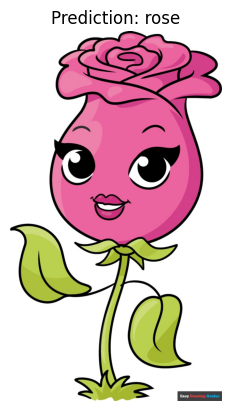

In [ ]:
from PIL import Image

# Upload test image
print("\n⬆️ Upload a flower image to test:")
test = files.upload()
test_image_path = list(test.keys())[0]

# Preprocess and predict
image = Image.open(test_image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

class_names = dataset.classes
print(f"\n🌼 Predicted Class: {class_names[predicted.item()]}")

# Show Image
plt.imshow(image)
plt.title(f"Prediction: {class_names[predicted.item()]}")
plt.axis('off')
plt.show()